https://colab.research.google.com/drive/1PMeURbMa7aJ2w3Xg7EH7EDgJyYCGjQq6?usp=sharing

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [2]:
! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-d29_2rhc
  Resolved https://github.com/quantiacs/toolbox.git to commit 272e66e017d3eb6d40517ffa39cd6a92dc5072d8
  Preparing metadata (setup.py) ... done


In [3]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0   8219      0 --:--:-- --:--:-- --:--:--  8206
100  517k  100  517k    0     0   414k      0  0:00:01  0:00:01 --:--:--  414k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4159    0  4159    0     0   8572      0 --:--:-- --:--:-- --:--:--  8575
100  392k  100  392k    0     0   335k      0  0:00:01  0:00:01 --:--:-- 1852k


In [4]:
import os

os.environ['API_KEY'] = '2321659b-87c9-449f-ae8e-007643da74cb'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'


In [5]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

# Se elige la regresión de bosque aleatorio por su capacidad para modelar relaciones no lineales y su robustez al sobreajuste.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [6]:
# Cargar todos los activos del S&P 500
stock_data = qndata.stocks.load_spx_data(tail=365 * 5, assets = [
    "NAS:AAPL", "NAS:MSFT", "NAS:GOOGL", "NAS:NVDA", "NAS:META",
    "NAS:TSLA", "NAS:AMZN", "NYS:UNH", "NYS:JNJ", "NYS:JPM",
    "NYS:V", "NYS:XOM", "NYS:NEE", "NYS:PG", "NYS:KO",
    "NAS:COST", "NAS:CSCO", "NYS:NKE", "NYS:DIS", "NYS:WM"
])

# Se eligen empresas con alta capitalización, liquidez, y relevancia en sus industrias.

# Activos seleccionados:
# 1. AAPL, MSFT, GOOGL, NVDA, META (Tecnología): Lideran la innovación en sus campos.
# 2. TSLA, AMZN, COST (Consumo discrecional): Líderes en comercio y tecnología de consumo.
# 3. UNH, JNJ (Salud): Compañías dominantes en servicios médicos y productos farmacéuticos.
# 4. JPM, V (Finanzas): Bancos y pagos digitales con alta liquidez.
# 5. XOM, NEE (Energía): Diversificación entre petróleo y energías renovables.
# 6. PG, KO (Bienes de consumo): Marcas globales con productos esenciales.
# 7. DIS (Comunicación): Entretenimiento y medios globalmente reconocidos.
# 8. WM (Servicios públicos): Sostenibilidad y gestión de residuos.

# Justificación:
    # - Diversificación sectorial: Mitiga riesgos al cubrir distintos sectores.
    # - Alta capitalización y liquidez: Empresas dominantes con alta negociación.
    # - Relevancia y sostenibilidad: Adaptabilidad al futuro y crecimiento continuo.
    # - Reconocimiento global: Confianza y estabilidad en el mercado.



| | #                                             | 15975 Elapsed Time: 0:00:00


fetched chunk 1/1 0s
Data loaded 1s


In [20]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").rename({"field": "new_field"})
    macd2_signal = macd2_signal.assign_coords(field="macd").drop_vars("new_field")

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    price = price.assign_coords(field="price")

    # ATR (Average True Range)
    true_range = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    atr = qnta.lwma(true_range, 14)
    atr = atr.assign_coords(field="atr")
    # El ATR cuantifica la volatilidad del mercado evaluando el rango promedio de precios durante un período determinado.

    # EMA (Exponential Moving Average)
    ema = qnta.ema(data.sel(field="close"), 20)
    ema = ema.assign_coords(field="ema")
    # La EMA asigna mayor peso a los precios recientes, lo que permite captar cambios en la tendencia con mayor sensibilidad.

    # On-Balance Volume
    if 'volume' in data.field:
        obv = data.sel(field="close")
        volume = data.sel(field="volume")
        obv = volume.where(obv.diff("time") > 0, -volume).cumsum("time")
    else:
        # If 'volume' is not present, fill with 1s
        obv = xr.ones_like(data.sel(field="close"))
    obv = obv.assign_coords(field="obv")
    #  El OBV calcula el volumen acumulado ponderado por el movimiento del precio, identificando tendencias respaldadas por el flujo de volumen.

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal, volatility,  d, rsi, price, atr, ema, obv],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "atr", "ema", "obv"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [22]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:DIS,NYS:JNJ,NYS:JPM,NYS:KO,NYS:NEE,NYS:NKE,NYS:PG,NYS:UNH,NYS:V,NYS:WM,NYS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.197790,0.215067,-0.049518,0.106683,0.257012,-0.010902,-0.037366,-0.106488,0.713199,0.174467,-0.221004,0.076606,-0.142964,-0.248578,-0.110875,-0.050616,-0.366914,0.152817,-0.206205,-0.268213
2025-01-02,0.102707,0.218922,-0.073774,0.094910,0.251988,0.066019,-0.060286,-0.015386,0.467582,0.150354,-0.228849,0.074016,-0.158034,-0.243850,-0.191134,-0.082321,-0.367838,0.128505,-0.224098,-0.268138
2025-01-03,0.090928,0.269044,-0.052505,0.075180,0.286079,0.094443,-0.025156,0.125889,0.720124,0.151104,-0.220050,0.112223,-0.156760,-0.221518,-0.201722,-0.098362,-0.311007,0.126577,-0.206390,-0.244298


In [23]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [24]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:AMZN,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:META,NAS:MSFT,NAS:NVDA,NAS:TSLA,NYS:DIS,NYS:JNJ,NYS:JPM,NYS:KO,NYS:NEE,NYS:NKE,NYS:PG,NYS:UNH,NYS:V,NYS:WM,NYS:XOM
time,,,,,,,,,,,,,,,,,,,,
2020-01-13,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,1,1,0
2020-01-14,0,0,1,1,1,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0
2020-01-15,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0
2020-01-16,1,0,1,0,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0
2020-01-17,0,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2025-01-02,0,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1
2025-01-03,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0


In [25]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    model = RandomForestRegressor()
    return model

In [26]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

<ipython-input-26-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-26-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-26-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-26-383029879c06>:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-26-383029879c06>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

{'NAS:AAPL': RandomForestRegressor(), 'NAS:AMZN': RandomForestRegressor(), 'NAS:COST': RandomForestRegressor(), 'NAS:CSCO': RandomForestRegressor(), 'NAS:GOOGL': RandomForestRegressor(), 'NAS:META': RandomForestRegressor(), 'NAS:MSFT': RandomForestRegressor(), 'NAS:NVDA': RandomForestRegressor(), 'NAS:TSLA': RandomForestRegressor(), 'NYS:DIS': RandomForestRegressor(), 'NYS:JNJ': RandomForestRegressor(), 'NYS:JPM': RandomForestRegressor(), 'NYS:KO': RandomForestRegressor(), 'NYS:NEE': RandomForestRegressor(), 'NYS:NKE': RandomForestRegressor(), 'NYS:PG': RandomForestRegressor(), 'NYS:UNH': RandomForestRegressor(), 'NYS:V': RandomForestRegressor(), 'NYS:WM': RandomForestRegressor(), 'NYS:XOM': RandomForestRegressor()}


Feature: 0, Score: 0.12513
Feature: 1, Score: 0.12668
Feature: 2, Score: 0.12408
Feature: 3, Score: 0.15748
Feature: 4, Score: 0.14871
Feature: 5, Score: 0.09404
Feature: 6, Score: 0.12714
Feature: 7, Score: 0.09674
Feature: 8, Score: 0.00000


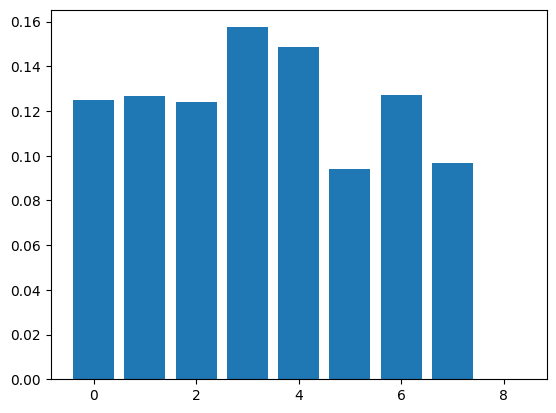

In [27]:
# Showing which features are more important in predicting:

# Changed the asset name from 'NAS:APPL' to 'NAS:AAPL'
importance = models["NAS:META"].feature_importances_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [28]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

<xarray.DataArray 'stocks_s&p500' (time: 1255, asset: 20)> Size: 201kB
array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.66, 0.88, 0.82, ..., 0.26, 0.86, 0.22],
       [0.17, 0.12, 0.14, ..., 0.13, 0.8 , 0.7 ],
       [0.19, 0.18, 0.15, ..., 0.13, 0.2 , 0.1 ]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:AMZN' ... 'NYS:WM' 'NYS:XOM'
  * time     (time) datetime64[ns] 10kB 2020-01-13 2020-01-14 ... 2025-01-07
    field    <U5 20B 'close'


<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-28-d5c983142616>:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



In [29]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

11.325574558526842

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [30]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2024-12-31,196.001886,0.002677,0.167909,-0.013825,-0.118695,11.289885,1.895678,1.0,20.0,0.585057,3.257596
2025-01-02,196.191284,0.000966,0.167849,-0.012872,-0.118695,11.282660,1.893782,1.0,20.0,0.585376,3.258264
2025-01-03,199.372804,0.016216,0.167867,0.000000,-0.118695,11.322632,1.900699,1.0,20.0,0.585449,3.257723
2025-01-06,201.171443,0.009021,0.167814,0.000000,-0.118695,11.342770,1.903472,1.0,20.0,0.585367,3.258321
2025-01-07,200.846491,-0.001615,0.167768,-0.001615,-0.118695,11.325575,1.900065,1.0,20.0,0.585751,3.258552


time,2025-01-07
field,
sharpe_ratio,11.325575


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [31]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.765443627215003

In [32]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.7676887711863633

In [33]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.19312509960159338

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [34]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [35]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [36]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


<ipython-input-35-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...
fetched chunk 1/1 0s
Data loaded 0s


<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was de

---
Run all iterations...
Load data...


<ipython-input-35-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-35-df9da7badac1>:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

| | #                                              | 9061 Elapsed Time: 0:00:00
| |              #                              | 2758889 Elapsed Time: 0:00:01


fetched chunk 1/8 3s


| |              #                              | 2774859 Elapsed Time: 0:00:01


fetched chunk 2/8 6s


| |            #                                | 2583044 Elapsed Time: 0:00:01


fetched chunk 3/8 9s


| |                                          #  | 3056326 Elapsed Time: 0:00:04


fetched chunk 4/8 16s


| |              #                              | 3177510 Elapsed Time: 0:00:01


fetched chunk 5/8 19s


| |              #                              | 3385220 Elapsed Time: 0:00:01


fetched chunk 6/8 22s


| |              #                              | 3548104 Elapsed Time: 0:00:01


fetched chunk 7/8 25s


| |              #                              | 3170701 Elapsed Time: 0:00:01


fetched chunk 8/8 28s
Data loaded 29s


| | #                                              | 9061 Elapsed Time: 0:00:00
| |              #                              | 2870356 Elapsed Time: 0:00:01


fetched chunk 1/7 3s


| |              #                              | 2960876 Elapsed Time: 0:00:01


fetched chunk 2/7 6s


| |              #                              | 2994899 Elapsed Time: 0:00:01


fetched chunk 3/7 9s


| |              #                              | 3206485 Elapsed Time: 0:00:01


fetched chunk 4/7 12s


| |              #                              | 3460109 Elapsed Time: 0:00:01


fetched chunk 5/7 15s


| |              #                              | 3543878 Elapsed Time: 0:00:01


fetched chunk 6/7 18s


| |                           #                 | 2645875 Elapsed Time: 0:00:02


fetched chunk 7/7 22s
Data loaded 24s
Backtest...


Se han truncado las últimas 5000 líneas del flujo de salida.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

<ipython-input-34-3636d5c2d255>:13: FutureWarn

fetched chunk 1/7 9s


| |              #                              | 2938852 Elapsed Time: 0:00:01


fetched chunk 2/7 16s


| |              #                              | 2890484 Elapsed Time: 0:00:01


fetched chunk 3/7 25s


| |              #                              | 3076543 Elapsed Time: 0:00:01


fetched chunk 4/7 32s


| |              #                              | 3372611 Elapsed Time: 0:00:01


fetched chunk 5/7 38s


| |               #                             | 3518459 Elapsed Time: 0:00:01


fetched chunk 6/7 43s


| |              #                              | 3226130 Elapsed Time: 0:00:01


fetched chunk 7/7 50s
Data loaded 50s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-07
Sharpe Ratio = 0.7384697273853194
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5037 of 5037) |####################| Elapsed Time: 0:11:17 Time:  0:11:17


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!